In [1]:
# ===================================================================
# Cellule 1 : Import des bibliothèques et configuration initiale
# ===================================================================
import os
import gc
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import psutil
from sklearn.manifold import TSNE
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve
from io import StringIO
import json
from datetime import datetime

# Import de PyTorch Geometric
try:
    from torch_geometric.data import Data
    from torch_geometric.nn import GCNConv, VGAE
    from torch_geometric.utils import train_test_split_edges, negative_sampling
    import torch.nn.functional as F
except ImportError:
    print("ERREUR: PyTorch Geometric n'est pas installé.")
    print("Veuillez l'installer, par exemple avec : pip install torch-geometric")
    # Pour Colab, des commandes plus spécifiques peuvent être nécessaires.
    exit()

# Configuration de l'affichage et des visualisations
%matplotlib inline
pd.set_option('display.max_columns', None)
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (14, 8)

# Définition de l'appareil (GPU si disponible, sinon CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Utilisation de l'appareil : {device}")

Utilisation de l'appareil : cpu


In [2]:
# ===================================================================
# Cellule 2 : Chargement et préparation des nouvelles données (v3)
# ===================================================================
# Noms des fichiers de la version 3 avec géo-features
graph_path = 'construction/credential_stuffing_graph_v3.pt'
mapping_path = 'construction/node_mapping_v3.pt'

if not os.path.exists(graph_path) or not os.path.exists(mapping_path):
    raise FileNotFoundError(
        "Fichiers de graphe V3 non trouvés. "
        "Assurez-vous d'avoir exécuté 'construction_graphe.ipynb' avec les modifications pour les caractéristiques géographiques."
    )

# Charger les objets PyG et le mapping
data = torch.load(graph_path, weights_only=False)
idx_to_node = torch.load(mapping_path, weights_only=False)
node_to_idx = {v: k for k, v in idx_to_node.items()}

print("--- Graphe V3 chargé (avec géo-features) ---")
print(data)
print(f"Nombre de caractéristiques par nœud : {data.num_node_features}")

# --- MODIFICATION : Remplacer la normalisation Z-score par une normalisation Min-Max ---
# Cette méthode est plus robuste aux outliers, ce qui est crucial pour la stabilité.
x_min = data.x.min(dim=0, keepdim=True).values
x_max = data.x.max(dim=0, keepdim=True).values
data.x = (data.x - x_min) / (x_max - x_min + 1e-8) # +1e-8 pour éviter la division par zéro

# Remplacer les NaN qui pourraient apparaître si une colonne est constante (max=min)
data.x = torch.nan_to_num(data.x, nan=0.0)
print("\nCaractéristiques des nœuds normalisées (Min-Max).")


# Déplacer les données vers le bon appareil
data = data.to(device)
print(f"Données déplacées vers '{device}'.")

# --- Reconstruction d'un DataFrame de caractéristiques pour l'analyse ---
feature_names = [
    'is_ip', 'is_user', 'degree', 'total_attempts', 
    'failure_rate', 'specific_feature', 
    'num_countries', 'num_cities'
]
node_features_df = pd.DataFrame(data.x.cpu().numpy(), columns=feature_names)
node_features_df['node_id'] = node_features_df.index.map(idx_to_node.get)
node_features_df = node_features_df.set_index('node_id')

print("\nAperçu du DataFrame des caractéristiques (avec géo-features) :")
display(node_features_df.head())

--- Graphe V3 chargé (avec géo-features) ---
Data(x=[14671, 8], edge_index=[2, 32774], edge_attr=[32774, 3])
Nombre de caractéristiques par nœud : 8

Caractéristiques des nœuds normalisées (Min-Max).
Données déplacées vers 'cpu'.

Aperçu du DataFrame des caractéristiques (avec géo-features) :


,is_ip,is_user,degree,total_attempts,failure_rate,specific_feature,num_countries,num_cities
node_id,,,,,,,,
674a135355e8b1e1e55b932e176415c3c85290676ff72ce8a7d14db986becc84,1.0,0.0,0.000000,0.000308,0.0,0.000000,0.0,0.0
cfd5065ab4d87895601e26bd782055667e7b9d033424b6707a5d3f68cbc82791,1.0,0.0,1.000000,1.000000,0.0,1.000000,0.0,0.0
fe14787607e69d705c79db451fa77bbe721ac9f1c55b6fc88b7427bf3b32a792,1.0,0.0,0.521959,0.421572,0.0,0.521959,0.0,0.0
95b951dd7f08f826d2d37ae08e55d3ae1495a34296b14ef80af0a0a70b6e0faa,1.0,0.0,0.000000,0.000924,0.0,0.000000,0.0,0.0
87d85321a85e642c79f0959209819f3b67002c2eda400ac6d8eee2d58f0581d1,1.0,0.0,0.979013,0.985516,0.0,0.979013,0.0,0.0


In [3]:
# ===================================================================
# Cellule 3 : Définition des classes de modèles (GAE) - (MODIFIÉE)
# ===================================================================
from torch_geometric.nn import GAE

# --- 1. Encodeur GAE de base ---
# Cet encodeur apprend un embedding (z) directement, sans mu ni logstd.
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels, cached=True)
        self.conv2 = GCNConv(hidden_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        return self.conv2(x, edge_index)

# --- 2. Encodeur GAE amélioré (avec Dropout pour la régularisation) ---
class ImprovedGCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels, cached=True)
        self.dropout = dropout
        self.conv2 = GCNConv(hidden_channels, out_channels, cached=True)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index).relu()
        x = F.dropout(x, p=self.dropout, training=self.training)
        return self.conv2(x, edge_index)

# Note : Nous n'avons plus besoin de notre classe CustomVGAE.
# La classe GAE de PyTorch Geometric gère le décodage pour nous.
print("Classes des modèles GAE définies.")

Classes des modèles GAE définies.


In [4]:
# ===================================================================
# CELLULE 4 : Fonction d'entraînement et d'évaluation (MODIFIÉE pour GAE)
# ===================================================================

def train_model(model, train_data, epochs, lr=0.01, weight_decay=1e-5):
    """Fonction générique pour entraîner notre GAE."""
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    losses = []
    for epoch in range(1, epochs + 1):
        optimizer.zero_grad()
        
        # Le modèle GAE encode les données pour obtenir z
        z = model.encode(train_data.x, train_data.train_pos_edge_index)
        
        # La perte est simplement l'erreur de reconstruction sur les arêtes positives
        loss = model.recon_loss(z, train_data.train_pos_edge_index)
                
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        
        if epoch % 20 == 0 or epoch == 1:
            print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
            
    return model, losses

# --- Fonction d'évaluation pour GAE ---
def evaluate_model(model, data):
    """Évalue un modèle GAE sur les ensembles de validation et de test."""
    model.eval()
    with torch.no_grad():
        z = model.encode(data.x, data.train_pos_edge_index)
        
        # Validation
        pos_pred_val = model.decode(z, data.val_pos_edge_index)
        neg_pred_val = model.decode(z, data.val_neg_edge_index)
        y_pred_val = torch.cat([pos_pred_val, neg_pred_val]).cpu()
        y_true_val = torch.cat([torch.ones_like(pos_pred_val), torch.zeros_like(neg_pred_val)]).cpu()
        
        val_auc = roc_auc_score(y_true_val, y_pred_val)
        val_ap = average_precision_score(y_true_val, y_pred_val)

        # Test
        pos_pred_test = model.decode(z, data.test_pos_edge_index)
        neg_pred_test = model.decode(z, data.test_neg_edge_index)
        y_pred_test = torch.cat([pos_pred_test, neg_pred_test]).cpu()
        y_true_test = torch.cat([torch.ones_like(pos_pred_test), torch.zeros_like(neg_pred_test)]).cpu()
        
        test_auc = roc_auc_score(y_true_test, y_pred_test)
        test_ap = average_precision_score(y_true_test, y_pred_test)
    
    return val_auc, val_ap, test_auc, test_ap

print("Fonctions d'entraînement et d'évaluation GAE prêtes.")

Fonctions d'entraînement et d'évaluation GAE prêtes.


/Users/ismail/PING14/.venv/lib/python3.13/site-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


Données divisées pour l'entraînement/validation/test :
 Data(x=[14671, 8], val_pos_edge_index=[2, 819], val_pos_edge_attr=[819, 3], test_pos_edge_index=[2, 1638], test_pos_edge_attr=[1638, 3], train_pos_edge_index=[2, 27860], train_pos_edge_attr=[27860, 3], train_neg_adj_mask=[14671, 14671], val_neg_edge_index=[2, 819], test_neg_edge_index=[2, 1638])

--- Entraînement du Modèle GAE Original ---
Epoch: 001, Loss: 0.9821
Epoch: 020, Loss: 0.7957
Epoch: 040, Loss: 0.7566
Epoch: 060, Loss: 0.7398
Epoch: 080, Loss: 0.7312
Epoch: 100, Loss: 0.7301
Epoch: 120, Loss: 0.7306
Epoch: 140, Loss: 0.7285
Epoch: 160, Loss: 0.7292
Epoch: 180, Loss: 0.7317
Epoch: 200, Loss: 0.7255

--- Entraînement du Modèle GAE Amélioré ---
Epoch: 001, Loss: 0.9917
Epoch: 020, Loss: 0.8325
Epoch: 040, Loss: 0.7872
Epoch: 060, Loss: 0.7782
Epoch: 080, Loss: 0.7679
Epoch: 100, Loss: 0.7584
Epoch: 120, Loss: 0.7486
Epoch: 140, Loss: 0.7433
Epoch: 160, Loss: 0.7426
Epoch: 180, Loss: 0.7413
Epoch: 200, Loss: 0.7344

--- Év

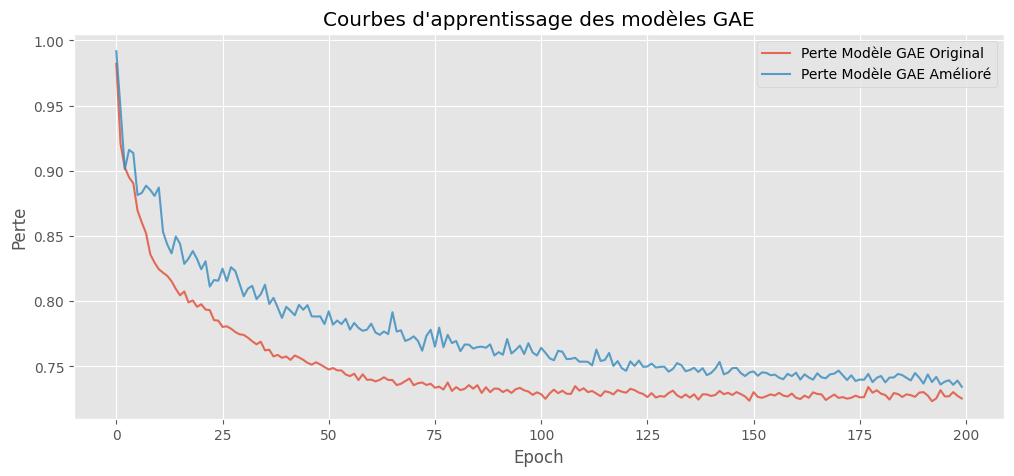

In [5]:
# ===================================================================
# Cellule 5 : Instanciation, Entraînement et Évaluation (MODIFIÉE pour GAE)
# ===================================================================
from torch_geometric.nn import GAE

original_edge_index = data.edge_index.clone()

# --- 1. Diviser les données ---
data_split = train_test_split_edges(data, val_ratio=0.05, test_ratio=0.1)
data_split = data_split.to(device)
print("Données divisées pour l'entraînement/validation/test :\n", data_split)

# --- 2. Définir les hyperparamètres ---
IN_CHANNELS = data.num_node_features
HIDDEN_CHANNELS = 64
LATENT_DIM = 32
EPOCHS = 200
LEARNING_RATE = 0.01

# --- 3. Modèle GAE Original ---
print("\n--- Entraînement du Modèle GAE Original ---")
encoder_orig = GCNEncoder(IN_CHANNELS, HIDDEN_CHANNELS, LATENT_DIM)
model_orig = GAE(encoder_orig).to(device)
model_orig, losses_orig = train_model(model_orig, data_split, epochs=EPOCHS, lr=LEARNING_RATE)

# --- 4. Modèle GAE Amélioré ---
print("\n--- Entraînement du Modèle GAE Amélioré ---")
encoder_imp = ImprovedGCNEncoder(IN_CHANNELS, HIDDEN_CHANNELS, LATENT_DIM)
model_improved = GAE(encoder_imp).to(device)
model_improved, losses_imp = train_model(model_improved, data_split, epochs=EPOCHS, lr=LEARNING_RATE)

# --- 5. Évaluation comparative ---
print("\n--- Évaluation finale ---")
val_auc_orig, val_ap_orig, test_auc_orig, test_ap_orig = evaluate_model(model_orig, data_split)
val_auc_imp, val_ap_imp, test_auc_imp, test_ap_imp = evaluate_model(model_improved, data_split)

results_df = pd.DataFrame({
    'Modèle': ['GAE Original', 'GAE Amélioré'],
    'Test AUC': [test_auc_orig, test_auc_imp],
    'Test AP': [test_ap_orig, test_ap_imp],
    'Val AUC': [val_auc_orig, val_auc_imp],
    'Val AP': [val_ap_orig, val_ap_imp]
})
print("\n--- RÉSULTATS COMPARATIFS ---")
print(results_df.round(4))

# --- 6. Visualisation des pertes ---
plt.figure(figsize=(12, 5))
plt.plot(losses_orig, label='Perte Modèle GAE Original', alpha=0.8)
plt.plot(losses_imp, label='Perte Modèle GAE Amélioré', alpha=0.8)
plt.title("Courbes d'apprentissage des modèles GAE")
plt.xlabel("Epoch")
plt.ylabel("Perte")
plt.legend()
plt.grid(True)
plt.show()


--- Top 10 IPs suspectes (Modèle GAE Original) ---


,failure_rate,degree,total_attempts,num_countries,num_cities,score_orig,score_imp
node_id,,,,,,,
193dc9232f995f082d3e796f7da6e363d52d592a5e7ba26a2a0f3a8618c256c7,0.00,0.0,0.000000,0.0,0.0,0.566668,0.908851
23a9f558a53c539075ec90e33566e490565236788a2442ae38e795254cec5b8e,0.00,0.0,0.000000,0.0,0.0,0.566668,0.908851
ccbc9aa265f4ce0cfe643cf4de27d3980707b4f8327574bcaa7e9fba4f8fa794,0.00,0.0,0.000000,0.0,0.0,0.566668,0.908851
ef839b54126b89e8a7fefdef72daa8aed6dc5bf560af8a6486a9bcb93d75143d,0.00,0.0,0.000000,0.0,0.0,0.566668,0.908851
c9059011609454f392ba2aec55eb6082857d3ca4d70b0470cba6307e5690db86,0.00,0.0,0.000308,0.0,0.0,0.565411,0.908769
9590b087ff200007d3420f46ee1ea49536bf98640900d50e27e5e3d00abcb977,0.00,0.0,0.000308,0.0,0.0,0.565396,0.908653
0448aac70381bf63e9d41beff5f73f9e5cd04e62b1474f2ddd8220dbc82ce6d4,0.00,0.0,0.000308,0.0,0.0,0.562612,0.775718
3002560e45854f39ac8c67d6a2d16825dae63679a7564d25094e47d36bbe21fa,0.00,0.0,0.000308,0.0,0.0,0.557740,0.720837
6e5e335c7cd4d064a8bc54c8c3e9c25169f5cf1cfc15a6aa494326a35750e2dd,0.00,0.0,0.000308,0.0,0.0,0.555547,0.692402



--- Top 10 IPs suspectes (Modèle GAE Amélioré) ---


,failure_rate,degree,total_attempts,num_countries,num_cities,score_orig,score_imp
node_id,,,,,,,
ccbc9aa265f4ce0cfe643cf4de27d3980707b4f8327574bcaa7e9fba4f8fa794,0.0,0.0,0.000000,0.0,0.0,0.566668,0.908851
ef839b54126b89e8a7fefdef72daa8aed6dc5bf560af8a6486a9bcb93d75143d,0.0,0.0,0.000000,0.0,0.0,0.566668,0.908851
23a9f558a53c539075ec90e33566e490565236788a2442ae38e795254cec5b8e,0.0,0.0,0.000000,0.0,0.0,0.566668,0.908851
193dc9232f995f082d3e796f7da6e363d52d592a5e7ba26a2a0f3a8618c256c7,0.0,0.0,0.000000,0.0,0.0,0.566668,0.908851
c9059011609454f392ba2aec55eb6082857d3ca4d70b0470cba6307e5690db86,0.0,0.0,0.000308,0.0,0.0,0.565411,0.908769
9590b087ff200007d3420f46ee1ea49536bf98640900d50e27e5e3d00abcb977,0.0,0.0,0.000308,0.0,0.0,0.565396,0.908653
e415a0adb8e7b41fad856cf0586222ea2b8ba84049459724da548c66d928ce6d,0.0,0.0,0.000000,0.0,0.0,0.553118,0.800641
cd244fefc9d43742a005857f167fae9559823fc6689fde6ac12c87a2ba817ae7,0.0,0.0,0.000000,0.0,0.0,0.548955,0.791801
46a73b82e7cdabb31a56e690514376bc80566e7d58233810901df17391971977,0.0,0.0,0.000000,0.0,0.0,0.550703,0.791331


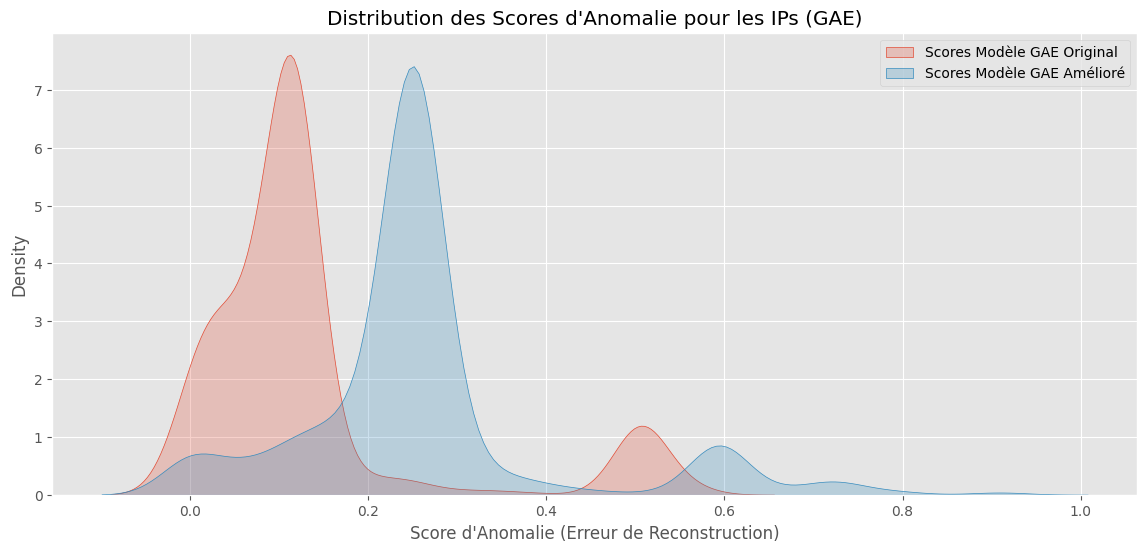

In [6]:
# =====================================================================
# Cellule 6 : Détection d'anomalies et analyse - (MODIFIÉE pour GAE)
# =====================================================================

def get_anomaly_scores(model, data_split_obj, full_edge_index):
    """Calcule les erreurs de reconstruction pour tous les nœuds avec un modèle GAE."""
    model.eval()
    with torch.no_grad():
        # L'encodeur GAE retourne directement z
        z = model.encode(data_split_obj.x, data_split_obj.train_pos_edge_index)
        
        # Calcul manuel de la matrice d'adjacence reconstruite
        adj_recon = torch.sigmoid(torch.matmul(z, z.t()))
        recon_error_matrix = 1 - adj_recon
        
        node_errors = torch.zeros(data_split_obj.num_nodes, device=device)
        
        row, col = full_edge_index
        
        edge_errors = recon_error_matrix[row, col]
        node_errors.scatter_add_(0, row, edge_errors)
        node_errors.scatter_add_(0, col, edge_errors)
        
        degrees = torch.bincount(row, minlength=data_split_obj.num_nodes) + torch.bincount(col, minlength=data_split_obj.num_nodes)
        node_errors /= degrees.clamp(min=1)
        
    return node_errors.cpu().numpy()

scores_orig = get_anomaly_scores(model_orig, data_split, original_edge_index)
scores_imp = get_anomaly_scores(model_improved, data_split, original_edge_index)

# Créer un DataFrame avec les scores et les caractéristiques
anomaly_df = node_features_df.copy()
anomaly_df['score_orig'] = scores_orig
anomaly_df['score_imp'] = scores_imp

# Identifier les nœuds de type IP
ip_anomaly_df = anomaly_df[anomaly_df['is_ip'] > 0.5].copy()

cols_to_display = [
    'failure_rate', 'degree', 'total_attempts', 
    'num_countries', 'num_cities',
    'score_orig', 'score_imp'
]

# Afficher les IPs les plus suspectes selon chaque modèle
print("\n--- Top 10 IPs suspectes (Modèle GAE Original) ---")
display(ip_anomaly_df.sort_values('score_orig', ascending=False).head(10)[cols_to_display])

print("\n--- Top 10 IPs suspectes (Modèle GAE Amélioré) ---")
display(ip_anomaly_df.sort_values('score_imp', ascending=False).head(10)[cols_to_display])

# Visualiser la distribution des scores d'anomalie
plt.figure(figsize=(14, 6))
sns.kdeplot(ip_anomaly_df['score_orig'], label='Scores Modèle GAE Original', fill=True)
sns.kdeplot(ip_anomaly_df['score_imp'], label='Scores Modèle GAE Amélioré', fill=True)
plt.title("Distribution des Scores d'Anomalie pour les IPs (GAE)")
plt.xlabel("Score d'Anomalie (Erreur de Reconstruction)")
plt.legend()
plt.show()

Calcul de t-SNE pour 'Espace Latent t-SNE - GAE Original'...


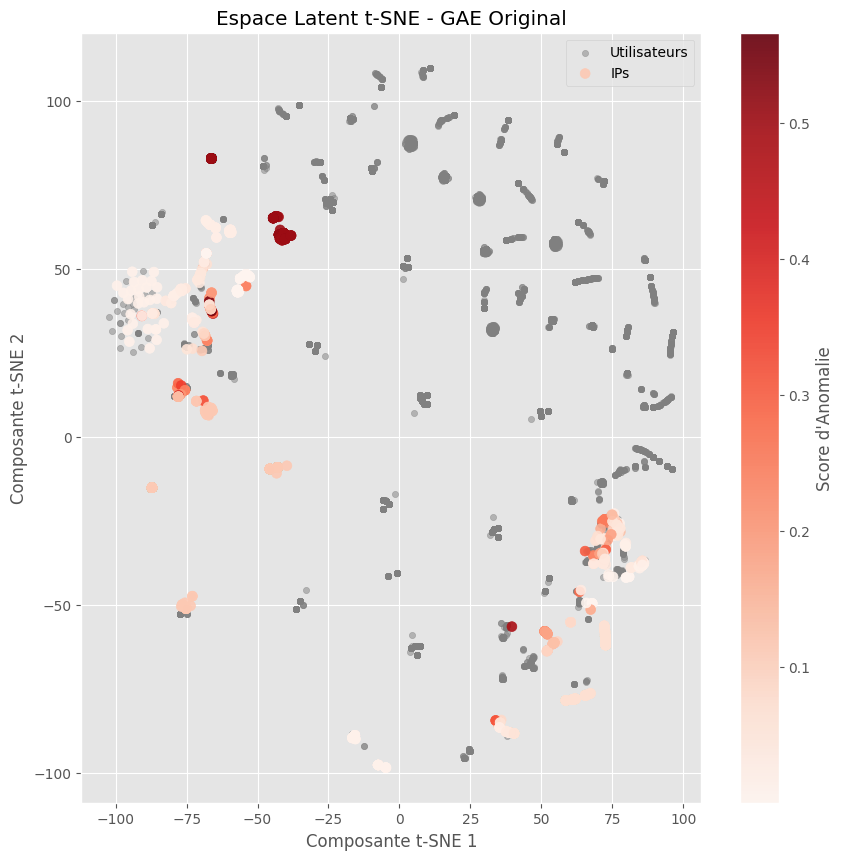

Calcul de t-SNE pour 'Espace Latent t-SNE - GAE Amélioré'...


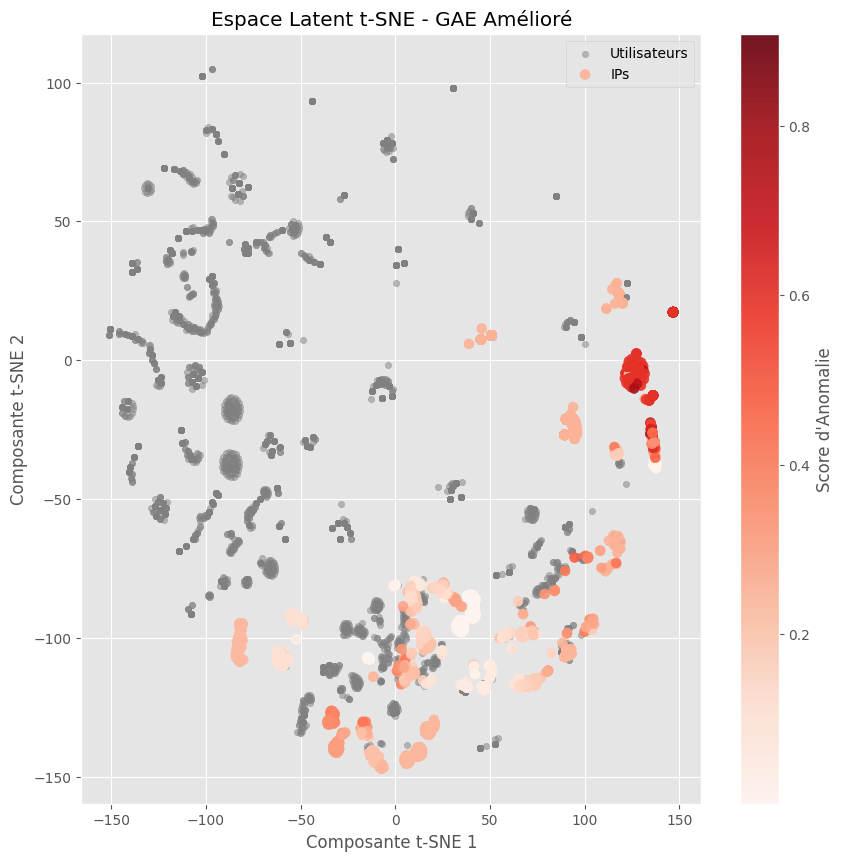

In [7]:
# =====================================================================
# Cellule 7 : Visualisation T-SNE des Espaces Latents - (MODIFIÉE pour GAE)
# =====================================================================

def visualize_tsne(model, data_split_obj, full_edge_index, title):
    """Génère et affiche une visualisation t-SNE de l'espace latent pour un GAE."""
    model.eval()
    with torch.no_grad():
        # L'encodeur GAE retourne directement z
        z = model.encode(data_split_obj.x, data_split_obj.train_pos_edge_index)
        z = z.cpu().numpy()
        
    # Appliquer t-SNE
    print(f"Calcul de t-SNE pour '{title}'...")
    tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
    z_tsne = tsne.fit_transform(z)
    
    # Séparer IPs et Utilisateurs pour la visualisation
    is_ip = data_split_obj.x[:, 0].cpu().numpy() > 0.5
    
    plt.figure(figsize=(10, 10))
    # Afficher les utilisateurs en premier (en arrière-plan)
    plt.scatter(z_tsne[~is_ip, 0], z_tsne[~is_ip, 1], s=20, color='gray', alpha=0.5, label='Utilisateurs')
    
    # Obtenir les scores d'anomalie pour la coloration
    ip_scores = get_anomaly_scores(model, data_split_obj, full_edge_index)[is_ip]
    plt.scatter(z_tsne[is_ip, 0], z_tsne[is_ip, 1], s=50, c=ip_scores, cmap='Reds', alpha=0.9, label='IPs')
    
    plt.title(title)
    plt.xlabel("Composante t-SNE 1")
    plt.ylabel("Composante t-SNE 2")
    plt.legend()
    cbar = plt.colorbar()
    cbar.set_label("Score d'Anomalie")
    plt.show()

# Appeler la fonction de visualisation pour les deux modèles
visualize_tsne(model_orig, data_split, original_edge_index, "Espace Latent t-SNE - GAE Original")
visualize_tsne(model_improved, data_split, original_edge_index, "Espace Latent t-SNE - GAE Amélioré")

In [8]:
# ===================================================================
# Cellule 8 : Sauvegarde des résultats et du meilleur modèle (v3)
# ===================================================================

results_dir = "results_v3_geo"
if not os.path.exists(results_dir):
    os.makedirs(results_dir)

# --- 1. Sauvegarder le meilleur modèle (basé sur le Test AP) ---
best_model = model_improved if test_ap_imp > test_ap_orig else model_orig
model_name = "gae_improved" if test_ap_imp > test_ap_orig else "gae_original"
model_path = os.path.join(results_dir, f"best_model_{model_name}.pt")
torch.save(best_model.state_dict(), model_path)
print(f"Meilleur modèle ('{model_name}') sauvegardé dans : {model_path}")

# --- 2. Sauvegarder le tableau de comparaison ---
comparison_path = os.path.join(results_dir, "model_comparison.csv")
results_df.to_csv(comparison_path, index=False)
print(f"Tableau de comparaison sauvegardé dans : {comparison_path}")

# --- 3. Sauvegarder la liste des IPs les plus suspectes ---
top_anomalies_path = os.path.join(results_dir, "top_anomalies.csv")

# Sauvegarder les anomalies du meilleur modèle
best_score_col = 'score_imp' if test_ap_imp > test_ap_orig else 'score_orig'
ip_anomaly_df.sort_values(best_score_col, ascending=False).head(100).to_csv(top_anomalies_path)
print(f"Top 100 des IPs suspectes sauvegardées dans : {top_anomalies_path}")

Meilleur modèle ('gae_improved') sauvegardé dans : results_v3_geo/best_model_gae_improved.pt
Tableau de comparaison sauvegardé dans : results_v3_geo/model_comparison.csv
Top 100 des IPs suspectes sauvegardées dans : results_v3_geo/top_anomalies.csv
